In [146]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

%matplotlib inline

In [147]:
# loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset_list = [train, test] # to do feature engineering and data cleaning
dataset_com = pd.concat(dataset_list,axis=0,sort=True)

In [148]:
# Exploring empty cells and cell type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [149]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* PassengerId — unique id - **no nulls**
* Survived — Survival - 0= No, 1 = yes - **not available for test data**
* Pclass — Ticket class	- 1 = 1st, 2 = 2nd, 3 = 3rd - **no nulls**
* Name — name of the passenger - **no nulls**
* Sex — Sex - **no nulls**
* Age — Age in years - **have nulls**
* SibSp — # of siblings / spouses aboard the Titanic - **no nulls**
* Parch — # of parents / children aboard the Titanic - **no nulls**
* Ticket — Ticket number - **no nulls**
* Fare — Passenger fare - **1 null in test data**
* Cabin - Cabin number - **null where no cabin - can replace null value with no_cabin**
* Embarked - Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton - **2 nulls in train data**

# Data Exploration and Feature Engineering

In [150]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [151]:
test.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


# Feature engineering

## Features inspired by https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
* Family Size as combination of SibSb + Parch - from Sina
* DoTicketNumberHasMultiple - may indicate traveling with friends/family
* GroupHasKid using ticket number( indicator of same group)
* IsAlone from FamilySize and DoTicketNumberHasMultiple - inspired from Sina
* Bins
    * Fare more like pclass++, if we use this can drop pclass as it become redundant.
    * Age Group - from Sina
    * Title based on extracted value - from Sina
* HasCabin
* CabinType based on Fare and HasCabin (0 - no cabin, 1 - shared cabin, 2 - private cabin) - this gives same information as pclass++, we can drop it, also if needed check via P-value.
* TravelTime in Days before hitting iceberg (15th April 1912) calculated based on embarkment port route of  S(11), C(5), Q(4) using info from https://discovernorthernireland.com/things-to-do/attractions/titanic/titanic-sailing-route-map/

In [152]:
# 1. FamilySize
for dataset in dataset_list:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


 seems to have good impact

In [153]:
# 2. IsAlone
# check if columns have duplicate ticket number. Duplicate ticket numbers symbolize family/friends
tks = dataset_com['Ticket']
dataset_dup = dataset_com[tks.isin(tks[tks.duplicated()])]

In [154]:
for dataset in dataset_list:
    dataset['TkDup'] = dataset.Ticket.isin(dataset_dup['Ticket'])

In [155]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,False


Now using family size and Tkdup as indicator of travel group we calculate whether person is alone in this ship or not

In [156]:
for dataset in dataset_list:
    dataset['IsAlone'] = 0
    dataset_filter = (dataset['FamilySize'] == 1) & (dataset['TkDup'] == False)
    dataset['IsAlone'] = np.where(dataset_filter, 1, 0)

In [157]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,False,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2,False,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,False,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,False,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,3,True,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,1,False,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,False,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,3,True,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,False,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,3,True,0


In [158]:
train[train['Ticket'] == '1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1,True,0
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1,True,0
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1,True,0
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,True,0
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1,True,0


Above shows case where though family size is 1 but ticket number is duplicate, these guys must belong to same group

In [159]:
# 3. pclass++ (update class if have cabin)
dataset_com.groupby('Pclass').count()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket
Pclass,,,,,,,,,,,
1,284,256,321,323,323,323,323,323,323,216,323
2,261,23,277,277,277,277,277,277,277,184,277
3,501,16,709,708,709,709,709,709,709,491,709


In [160]:
for dataset in dataset_list:
    dataset['pclass++'] = dataset['Pclass']
    dataset_filter = pd.notna(dataset['Cabin'])
    dataset['pclass++'] = np.where(dataset_filter, 0, dataset['pclass++'].values)

In [161]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,False,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,True,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,False,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,True,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,False,1,3


In [162]:
# 3. Embarked
# cleaning values
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,True,0,0


Since they have duplicate ticket number, we can use value from same ticket number

In [163]:
train[train.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,True,0,0


but since no other member same ticket number and both missing, we will assign value of most occured in same Pclass i.e. 1 here

In [164]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
dataset_com.groupby(['Embarked', 'pclass++']).size()

Embarked  pclass++
C         0           118
          1            30
          2            24
          3            98
Q         0             5
          2             6
          3           112
S         0           170
          1            37
          2           224
          3           483
dtype: int64

In [165]:
# Since majority of height class people embarked in S, assigning the same values
train['Embarked'] = train['Embarked'].fillna('S')

In [166]:
train[train.Ticket == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,1,True,0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,1,True,0,0


In [167]:
# 4 . Fare as we know only 1 value is missing in test data
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,False,1,3


In [168]:
# lets replace that with median value in that category
test.groupby('pclass++').median()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,TkDup,IsAlone
pclass++,,,,,,,,,
0,1094.0,1.0,39.0,1.0,0.0,61.9792,2.0,True,0
1,1109.0,1.0,43.5,0.0,0.0,31.6833,1.0,False,1
2,1121.5,2.0,27.5,0.0,0.0,18.5000,1.0,True,0
3,1091.5,3.0,24.0,0.0,0.0,7.8958,1.0,False,1


In [169]:
test.loc[test.Fare.isnull(), 'Fare'] = test.groupby('pclass++').Fare.transform('median')
test[test.PassengerId == 1044]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,TkDup,IsAlone,pclass++
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,7.8958,NaN,S,1,False,1,3


In [170]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
#updating list with new data

In [171]:
# Title derived from Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # regex starting with space ending with .
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in dataset_list:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [172]:
# 5. Title Group all non-common titles into group based on gender
for dataset in dataset_list:
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms', 'Countess', 'Lady', 'Dona'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Capt','Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr')

print(pd.crosstab(train['Title'], train['Sex']))

Sex     female  male
Title               
Dr           1     6
Master       0    40
Miss       187     0
Mr           0   531
Mrs        126     0


In [173]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
#updating combine list with new data

In [174]:
print (dataset_com[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0      Dr  0.428571
1  Master  0.575000
2    Miss  0.705882
3      Mr  0.158192
4     Mrs  0.793651


In [175]:
# 6. Age - as we have seen multiple values are missing, lets assign them mean value for particular class and title
train.groupby(['Title', 'pclass++']).mean()

PassengerId  Survived    Pclass        Age     SibSp  \
Title  pclass++                                                         
Dr     0          558.666667  0.666667  1.000000  41.666667  0.666667   
       1          714.000000  0.500000  1.000000  50.000000  1.000000   
       2          358.500000  0.000000  2.000000  38.500000  0.000000   
Master 0          432.285714  1.000000  1.714286   3.988571  0.857143   
       2          575.500000  1.000000  2.000000   2.388333  0.666667   
       3          374.814815  0.370370  3.000000   5.322609  3.037037   
Miss   0          419.862745  0.941176  1.215686  28.316327  0.450980   
       1          475.428571  1.000000  1.000000  30.833333  0.000000   
       2          441.233333  0.933333  2.000000  22.655172  0.233333   
       3          399.525253  0.494949  3.000000  16.514925  1.020202   
Mr     0          457.704082  0.377551  1.132653  41.267442  0.306122   
       1          401.800000  0.200000  1.000000  43.937500  0.080000   
       2          457.734043  0.074468  2.000000  33.405882  0.308511   
       3          460.168790  0.111465  3.000000  28.711111  0.289809   
Mrs    0          487.377778  0.933333  1.244444  38.475000  0.644444   
       1          453.833333  1.000000  1.000000  44.666667  0.833333   
       2          449.138889  0.916667  2.000000  33.388889  0.777778   
       3          415.153846  0.487179  3.000000  34.200000  0.641026   

                    Parch        Fare  FamilySize     TkDup   IsAlone  
Title  pclass++                                                        
Dr     0         0.000000   48.809733    1.666667  0.333333  0.666667  
       1         0.000000   86.625000    2.000000  0.500000  0.500000  
       2         0.000000   12.250000    1.000000  0.000000  1.000000  
Master 0         1.428571   65.269043    3.285714  1.000000  0.000000  
       2         1.333333   25.792367    3.000000  1.000000  0.000000  
       3         1.370370   28.758796    5.407407  1.000000  0.000000  
Miss   0         0.607843   95.808576    2.058824  0.784314  0.156863  
       1         0.000000  174.080357    1.000000  1.000000  0.000000  
       2         0.600000   20.617917    1.833333  0.466667  0.466667  
       3         0.515152   15.209895    2.535354  0.414141  0.525253  
Mr     0         0.295918   66.675597    1.602041  0.489796  0.500000  
       1         0.040000   44.433828    1.120000  0.320000  0.680000  
       2         0.117021   19.255141    1.425532  0.404255  0.574468  
       3         0.127389   11.356287    1.417197  0.200637  0.742038  
Mrs    0         0.422222   77.980187    2.066667  0.866667  0.133333  
       1         0.166667   95.214583    2.000000  1.000000  0.000000  
       2         0.750000   25.140278    2.527778  0.861111  0.138889  
       3         1.461538   18.619762    3.102564  0.846154  0.128205

In [176]:
# setting age to median value
for dataset in dataset_list:
    dataset.loc[dataset.Age.isnull(), 'Age'] = dataset.groupby(['Title', 'pclass++']).Age.transform('mean')

In [177]:
#6. Fill empty cabin with no cabin
for dataset in dataset_list:
    dataset.loc[dataset.Cabin.isnull(), 'Cabin'] = 'NoCabin'

In [178]:
#7. Time travelled S(11), C(5), Q(4)
for dataset in dataset_list:
    dataset['TimeTravelled'] = 11
    dataset_filter = (dataset['Embarked'] == 'C')
    dataset_filter_1 = (dataset['Embarked'] == 'Q')
    dataset['TimeTravelled'] = np.where(dataset_filter, 5, dataset['TimeTravelled'].values)
    dataset['TimeTravelled'] = np.where(dataset_filter_1, 4, dataset['TimeTravelled'].values)

In [179]:
# convert fields from float to int
for dataset in dataset_list:
    dataset['Age'] = dataset['Age'].astype('int64')
    dataset['Fare'] = dataset['Fare'].astype('int64')
    dataset['IsAlone'] = dataset['IsAlone'].astype('int64')

In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null int64
SibSp            891 non-null int64
Parch            891 non-null int64
Ticket           891 non-null object
Fare             891 non-null int64
Cabin            891 non-null object
Embarked         891 non-null object
FamilySize       891 non-null int64
TkDup            891 non-null bool
IsAlone          891 non-null int64
pclass++         891 non-null int64
Title            891 non-null object
TimeTravelled    891 non-null int64
dtypes: bool(1), int64(11), object(6)
memory usage: 119.3+ KB


In [181]:
# Feature selection
# Store our passenger ID for easy access
PassengerId = test['PassengerId']
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'TkDup', 'Pclass']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [182]:
train.head(3)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,0,male,22,1,0,7,S,2,0,3,Mr,11
1,1,female,38,1,0,71,C,2,0,0,Mrs,5
2,1,female,26,0,0,7,S,1,1,3,Miss,11


In [183]:
test.head(3)

,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,male,34,0,0,7,Q,1,1,3,Mr,4
1,female,47,1,0,7,S,2,0,3,Mrs,11
2,male,62,0,0,9,Q,1,1,2,Mr,4


In [184]:
# picking out the relevant attributes for regression modelling
correlation = train.corr(method='pearson')
columns = correlation.nlargest(7, 'Survived').index
columns

Index(['Survived', 'Fare', 'Parch', 'FamilySize', 'SibSp', 'Age',
       'TimeTravelled'],
      dtype='object')

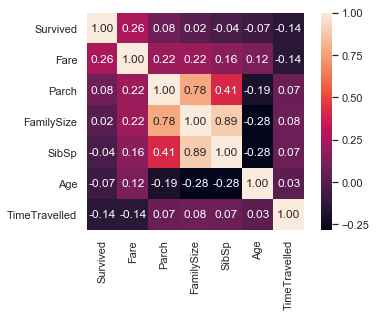

In [185]:
correlation_map = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

This shows family size and parch are coorelated

# Pairplots
Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


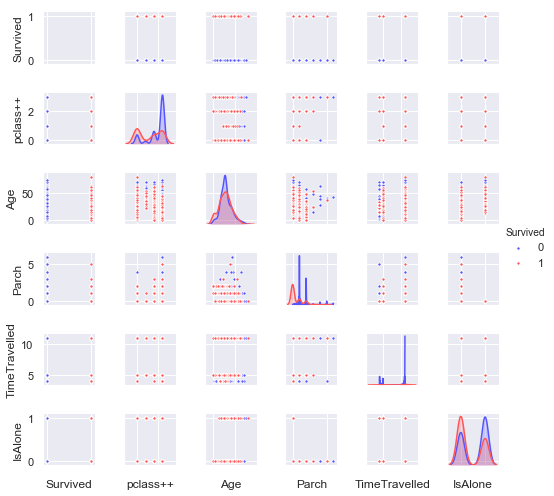

In [186]:
g = sns.pairplot(train[[u'Survived', u'pclass++', u'Age', u'Parch', u'TimeTravelled',
       u'IsAlone']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [187]:
dataset_com = pd.concat(dataset_list,axis=0,sort=True)
dataset_com = dataset_com.drop(drop_elements, axis=1)
#updating combine list with new data

In [188]:
dataset_com.head(1)
# X = dataset_com.iloc[:, :-1].values # features or independent variables

,Age,Embarked,FamilySize,Fare,IsAlone,Parch,Sex,SibSp,Survived,TimeTravelled,Title,pclass++
0,22,S,2,7,0,0,male,1,0.0,11,Mr,3


In [189]:
train.head(1)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,pclass++,Title,TimeTravelled
0,0,male,22,1,0,7,S,2,0,3,Mr,11


In [191]:
# preparing data for training and prediction
X = dataset_com.iloc[:,[6,0,7,5,3,1,2,4,11,10,9]].values
X_train = train.iloc[:,1:].values
y_train = train.iloc[:,0].values
X_test = test.values
# labels are sex 0, age 1, Sibsp 2, parch 3, Fare 4, embarked 5, family size 6, isAlone 7, pclass++ 8, title 9, timetravelled 10

In [192]:
X[1,:]

array(['female', 38, 1, 0, 71, 'C', 2, 0, 0, 'Mrs', 5], dtype=object)

In [193]:
X_train[1,:]

array(['female', 38, 1, 0, 71, 'C', 2, 0, 0, 'Mrs', 5], dtype=object)

In [194]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
# encoding sex
labelEncoder_sex = LabelEncoder()
labelEncoder_sex = labelEncoder_sex.fit(X[:,0]) # fitting on full set

In [195]:
X[:,0] = labelEncoder_sex.transform(X[:,0])

In [196]:
X_train[:,0] = labelEncoder_sex.transform(X_train[:,0])

In [197]:
X_test[:,0] = labelEncoder_sex.transform(X_test[:,0])

In [198]:
X_train[1,:]

array([0, 38, 1, 0, 71, 'C', 2, 0, 0, 'Mrs', 5], dtype=object)

In [199]:
X_test[1,:]

array([0, 47, 1, 0, 7, 'S', 2, 0, 3, 'Mrs', 11], dtype=object)

In [200]:
# encoding embarkment
labelEncoder_em = LabelEncoder()
labelEncoder_em = labelEncoder_em.fit(X[:,5]) # fitting on full set

In [201]:
X[:,5] = labelEncoder_em.transform(X[:,5])

In [202]:
X_train[:,5] = labelEncoder_em.transform(X_train[:,5])

In [203]:
X_test[:,5] = labelEncoder_em.transform(X_test[:,5])

In [204]:
# encoding Title
labelEncoder_ttl = LabelEncoder()
labelEncoder_ttl = labelEncoder_ttl.fit(X[:,9]) # fitting on full set

In [205]:
X[:,9] = labelEncoder_ttl.transform(X[:,9])

In [206]:
X_train[:,9] = labelEncoder_ttl.transform(X_train[:,9])
X_test[:,9] = labelEncoder_ttl.transform(X_test[:,9])

In [207]:
X[:3,:]

array([[1, 22, 1, 0, 7, 2, 2, 0, 3, 3, 11],
       [0, 38, 1, 0, 71, 0, 2, 0, 0, 4, 5],
       [0, 26, 0, 0, 7, 2, 1, 1, 3, 2, 11]], dtype=object)

In [208]:
# onehot encoding embarkment
from sklearn.preprocessing import OneHotEncoder
onehotencoder_em = OneHotEncoder(categorical_features = [5])
onehotencoder_em = onehotencoder_em.fit(X)

In [209]:
X = onehotencoder_em.transform(X).toarray()

In [210]:
X[:3,:]

array([[  0.,   0.,   1.,   1.,  22.,   1.,   0.,   7.,   2.,   0.,   3.,
          3.,  11.],
       [  1.,   0.,   0.,   0.,  38.,   1.,   0.,  71.,   2.,   0.,   0.,
          4.,   5.],
       [  0.,   0.,   1.,   0.,  26.,   0.,   0.,   7.,   1.,   1.,   3.,
          2.,  11.]])

In [211]:
X_train[:3,:]

array([[1, 22, 1, 0, 7, 2, 2, 0, 3, 3, 11],
       [0, 38, 1, 0, 71, 0, 2, 0, 0, 4, 5],
       [0, 26, 0, 0, 7, 2, 1, 1, 3, 2, 11]], dtype=object)

In [212]:
X_train = onehotencoder_em.transform(X_train).toarray()

In [213]:
X_train[:3,:]

array([[  0.,   0.,   1.,   1.,  22.,   1.,   0.,   7.,   2.,   0.,   3.,
          3.,  11.],
       [  1.,   0.,   0.,   0.,  38.,   1.,   0.,  71.,   2.,   0.,   0.,
          4.,   5.],
       [  0.,   0.,   1.,   0.,  26.,   0.,   0.,   7.,   1.,   1.,   3.,
          2.,  11.]])

In [214]:
X_test[:3,:]

array([[1, 34, 0, 0, 7, 1, 1, 1, 3, 3, 4],
       [0, 47, 1, 0, 7, 2, 2, 0, 3, 4, 11],
       [1, 62, 0, 0, 9, 1, 1, 1, 2, 3, 4]], dtype=object)

In [215]:
X_test = onehotencoder_em.transform(X_test).toarray()

In [216]:
X_test[:3,:]

array([[  0.,   1.,   0.,   1.,  34.,   0.,   0.,   7.,   1.,   1.,   3.,
          3.,   4.],
       [  0.,   0.,   1.,   0.,  47.,   1.,   0.,   7.,   2.,   0.,   3.,
          4.,  11.],
       [  0.,   1.,   0.,   1.,  62.,   0.,   0.,   9.,   1.,   1.,   2.,
          3.,   4.]])

In [217]:
# avoding dummy variable trap for embarkment by dropping one value
X = X[:,1:]
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [218]:
print(X.shape, X_train.shape, X_test.shape)

(1309, 12) (891, 12) (418, 12)


labels are em_1 (0), em_2(1), sex 3, age 4, Sibsp 5, parch 6, Fare 7, family size 8, isAlone 9, pclass++ 10, title 11, timetravelled 12

In [219]:
# onehot encoding title
from sklearn.preprocessing import OneHotEncoder
onehotencoder_ttl = OneHotEncoder(categorical_features = [9])
onehotencoder_ttl = onehotencoder_ttl.fit(X) # again fitting on full set

In [220]:
X = onehotencoder_ttl.transform(X).toarray()
X[:3,:] # five type of titles converted to five columns in start

array([[  0.,   0.,   0.,   1.,   0.,   1.,   1.,  22.,   1.,   0.,   7.,
          2.,   0.,   3.,  11.],
       [  1.,   0.,   0.,   0.,   0.,   0.,   0.,  38.,   1.,   0.,  71.,
          2.,   0.,   4.,   5.],
       [  0.,   0.,   0.,   1.,   0.,   1.,   0.,  26.,   0.,   0.,   7.,
          1.,   1.,   2.,  11.]])

In [221]:
X_train = onehotencoder_ttl.transform(X_train).toarray()

In [222]:
X_test = onehotencoder_ttl.transform(X_test).toarray()

In [223]:
# avoding dummy variable trap for title by dropping one value
X = X[:,1:]
X_train = X_train[:,1:]
X_test = X_test[:,1:]

In [224]:
X[:5,:]

array([[  0.,   0.,   1.,   0.,   1.,   1.,  22.,   1.,   0.,   7.,   2.,
          0.,   3.,  11.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  38.,   1.,   0.,  71.,   2.,
          0.,   4.,   5.],
       [  0.,   0.,   1.,   0.,   1.,   0.,  26.,   0.,   0.,   7.,   1.,
          1.,   2.,  11.],
       [  0.,   0.,   0.,   0.,   1.,   0.,  35.,   1.,   0.,  53.,   2.,
          0.,   4.,  11.],
       [  0.,   0.,   1.,   0.,   1.,   1.,  35.,   0.,   0.,   8.,   1.,
          1.,   3.,  11.]])

labels are ttl_1(0), ttl_2(1), ttl_3(2), ttl4(3), em_1 (4), em_2(5), sex 6, age 7, Sibsp 8, parch 9, Fare 10, family size 11, isAlone 12, pclass++ 13, timetravelled 14

In [226]:
print(X.shape, X_train.shape, X_test.shape)

(1309, 14) (891, 14) (418, 14)


# Baseline algorithm test

In [227]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [265]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# testing various classification models
pipelines = []

pipelines.append(('ScaledLOR', Pipeline([('Scaler', StandardScaler()),('LOR', LogisticRegression())])))
pipelines.append(('ScaledXGBC', Pipeline([('Scaler', StandardScaler()),('XGBC', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])))
pipelines.append(('ScaledKNC', Pipeline([('Scaler', StandardScaler()),('KNC', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC(kernel = 'rbf'))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', StandardScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier(criterion = 'entropy'))])))
pipelines.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier(n_estimators = 100))])))
pipelines.append(('ScaledABC', Pipeline([('Scaler', StandardScaler()),('ABC', AdaBoostClassifier())])))
pipelines.append(('ScaledGBC', Pipeline([('Scaler', StandardScaler()),('GBC', GradientBoostingClassifier())])))


results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledLOR: -0.195256 (0.025938)
ScaledXGBC: -0.166080 (0.033858)
ScaledKNC: -0.204245 (0.036382)
ScaledSVC: -0.172834 (0.038304)
ScaledGNB: -0.199725 (0.035460)
ScaledDTC: -0.209800 (0.043902)
ScaledRFC: -0.196355 (0.037662)
ScaledABC: -0.193021 (0.036733)
ScaledGBC: -0.176180 (0.033561)


In [263]:
# testing various classification models using f1 score
pipelines_1 = []
pipelines_1.append(('ScaledLOR', Pipeline([('Scaler', StandardScaler()),('LOR', LogisticRegression())])))
pipelines_1.append(('ScaledXGBC', Pipeline([('Scaler', StandardScaler()),('XGBC', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])))
pipelines_1.append(('ScaledKNC', Pipeline([('Scaler', StandardScaler()),('KNC', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))])))
pipelines_1.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC(kernel = 'rbf'))])))
pipelines_1.append(('ScaledGNB', Pipeline([('Scaler', StandardScaler()),('GNB', GaussianNB())])))
pipelines_1.append(('ScaledDTC', Pipeline([('Scaler', StandardScaler()),('DTC', DecisionTreeClassifier(criterion = 'entropy'))])))
pipelines_1.append(('ScaledRFC', Pipeline([('Scaler', StandardScaler()),('RFC', RandomForestClassifier(n_estimators = 100))])))
pipelines_1.append(('ScaledABC', Pipeline([('Scaler', StandardScaler()),('ABC', AdaBoostClassifier())])))
pipelines_1.append(('ScaledGBC', Pipeline([('Scaler', StandardScaler()),('GBC', GradientBoostingClassifier())])))


results = []
names = []
for name, model in pipelines_1:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.03f" % (name, np.mean(cv_results))
    print(msg)

ScaledLOR: 0.728
ScaledXGBC: 0.763
ScaledKNC: 0.719
ScaledSVC: 0.751
ScaledGNB: 0.739
ScaledDTC: 0.734
ScaledRFC: 0.742
ScaledABC: 0.739
ScaledGBC: 0.744


From the output above, it looks like XGBClassider out performs the best using a scaled version of the data.I will select XGBC for further analysis

# Lets optimize XGBC further using grid search

In [82]:
# from sklearn.model_selection import GridSearchCV

# scaler = StandardScaler().fit(X_train)
# rescaledX = scaler.transform(X_train)
# param_grid = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
# 'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4], 'n_estimators':[100,200], 'learning_rate':[0.1]}
# model = XGBClassifier(nthread=-1)
# kfold = KFold(n_splits=10, random_state=21)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
# grid_result = grid.fit(rescaledX, y_train)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [230]:
# Finalizing model and predicting using best parameters
scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
gbm = XGBClassifier().fit(rescaled_X_train, y_train)

In [231]:
rescaled_X_test = scaler.transform(X_test)
predictions = gbm.predict(rescaled_X_test)

In [232]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [237]:
from sklearn.metrics import make_scorer, accuracy_score 

rf_clf = RandomForestClassifier()

parameters_rf = {"n_estimators": [4, 5, 6, 7, 8, 9, 10, 15], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"], 
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=rf_clf, param_grid=parameters_rf, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.235690 (0.052078) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 4}
-0.207632 (0.040871) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 5}
-0.222222 (0.047288) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 6}
-0.218855 (0.049976) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 7}
-0.212121 (0.043133) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 8}
-0.198653 (0.042850) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 9}
-0.206510 (0.046110) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 10}
-0.209877 (0.030221) with: {'criterion': 'gini', 'max_depth': 2, 'max_featu

In [238]:
sb_model_2 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 'log2', min_samples_split  = 3, n_estimators = 100)

In [239]:
sb_model_2 = sb_model_2.fit(X_train, y_train)

In [240]:
predictions = sb_model_2.predict(X_test)

In [241]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [242]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [262]:
# Estimators not based on the Decision Tree requires standardised/scaled data:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scoring = []
results = []
models= [Perceptron(), SGDClassifier(), GaussianNB(), LogisticRegression(), \
         KNeighborsClassifier(n_neighbors=3), LinearSVC(), SVC(), DecisionTreeClassifier(),\
         RandomForestClassifier(n_estimators=100), AdaBoostClassifier(n_estimators=100),\
         GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=4), XGBClassifier()]
for model in models:
    ssmodel = make_pipeline(StandardScaler(), model)
    ssmodel.fit(X_train, y_train)
    y_Pred = ssmodel.predict(X_test)
    cv_results = cross_val_score(ssmodel, X_train, y_train, cv=10, scoring='f1')
    scoring.append(ssmodel.score(X_train, y_train))
    results.append(cv_results.mean())
    
df_scores = pd.DataFrame({"Model": models, "Score": scoring, "f1Score" : results})
df_scores.sort_values(by='Score', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linea

,Model,Score,f1Score
7,"DecisionTreeClassifier(class_weight=None, crit...",0.970819,0.736411
8,"(DecisionTreeClassifier(class_weight=None, cri...",0.970819,0.747723
10,([DecisionTreeRegressor(criterion='friedman_ms...,0.970819,0.761774
11,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.882155,0.757497
4,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.876543,0.738358
9,"(DecisionTreeClassifier(class_weight=None, cri...",0.852974,0.749970
6,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.851852,0.748427
3,"LogisticRegression(C=1.0, class_weight=None, d...",0.811448,0.729960
5,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.809203,0.734538
2,GaussianNB(priors=None),0.808081,0.742045


In [245]:
# RandomForrestClassifier, 100 trees:
model = models[8]
model.fit(X_train, y_train)
y_Pred = model.predict(X_test)
acc = round(model.score(X_train, y_train) * 100, 2)
acc

97.079999999999998